## CIFAR10 그룹 프로젝트

In [39]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from itertools import product
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Activation, BatchNormalization, ReLU, Add, Conv2D, MaxPool2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop, RandomFlip, RandomRotation
from tensorflow.keras.regularizers import l2


In [8]:
# 데이터 불러오기, 정리하기

from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

y_train = y_train.squeeze()
y_test = y_test.squeeze()

print(X_train.shape, y_train.shape,X_test.shape, y_train.shape, y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (50000,) (10000,)


In [9]:
# data augmentaion

data_augmentation = Sequential()
data_augmentation.add(ZeroPadding2D(4, input_shape=(32,32,3)))    # zero padding
data_augmentation.add(RandomCrop(32,32))                          # crop
data_augmentation.add(RandomFlip('horizontal'))                   # filp
data_augmentation.add(RandomRotation(0.05))                       # rotation


In [16]:
# DNN 확인

network = Sequential()

network.add(Flatten(input_shape=(32,32,3)))    #input
network.add(Dense(2048, activation='relu'))    #1
network.add(Dense(1024, activation='relu'))    #2
network.add(Dense(10, activation='softmax'))   #output

network_daug = Sequential()
network_daug.add(data_augmentation)
network_daug.add(network)

#network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
#network.fit(X_train, y_train, epochs=5, verbose=0)

network_daug.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
network_daug.fit(X_train, y_train, epochs=1, verbose=0)


In [15]:
# epoch=1

network.summary()
network.evaluate(X_test,y_test)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_8 (Dense)              (None, 10)                10250     
Total params: 8,401,930
Trainable params: 8,401,930
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 3s 9ms/step - loss: 1.4807 - acc: 0.4757


[1.480728268623352, 0.4756999909877777]

In [17]:
# data augmentation 했고, epoch = 1
# data 가 후질 때는 aug.. 한다고 좋아지는 것은 아님

network_daug.summary()
network_daug.evaluate(X_test,y_test)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 10)                8401930   
Total params: 8,401,930
Trainable params: 8,401,930
Non-trainable params: 0
_________________________________________________________________
313/313 [==============================] - 3s 9ms/step - loss: 2.0874 - acc: 0.2219


[2.08740496635437, 0.22190000116825104]

In [33]:
# 학습 중 그래프 표시하기
# plot 활용하는 콜백 클라스 정의

from IPython.display import clear_output

class PlottingCallback(tf.keras.callbacks.Callback):

    def __init__(self):
        self.logs = {'loss':[], 'val_loss':[], 'acc':[], 'val_acc':[]}
    
    def on_epoch_end(self, epoch, logs=None):
        self.logs['loss'].append(logs['loss'])
        self.logs['val_loss'].append(logs['val_loss'])
        self.logs['acc'].append(logs['acc'])
        self.logs['val_acc'].append(logs['val_acc'])

        clear_output()
        plt.figure(figsize=(8,4), dpi=150)
        
        plt.subplot(1,2,1)
        plt.plot(self.logs['loss'], label='train loss')
        plt.plot(self.logs['val_loss'], label='val loss')
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(self.logs['acc'], label='train acc')
        plt.plot(self.logs['val_acc'], label='val acc')        
        plt.legend()

        plt.show()
        print('Epoch: {}, Loss: {:7.5f}, Acc: {:5.2f}%'.format(epoch, logs['loss'], 100*logs['acc']))

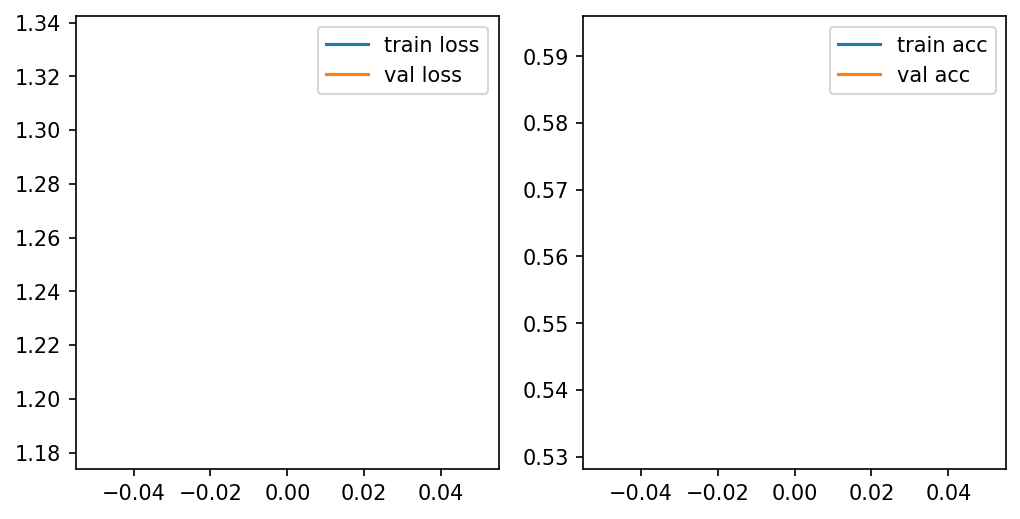

Epoch: 0, Loss: 1.33464, Acc: 53.12%
1563/1563 [==============================] - 488s 312ms/step - loss: 1.3346 - acc: 0.5312 - val_loss: 1.1814 - val_acc: 0.5929


In [32]:
# 알렉스넷, 배치놈 적용

alexnet = Sequential()

#1st layer : [Conv]+[ReLU]+[Pool]
#32*32*3
alexnet.add(Conv2D(input_shape=(32,32,3),   
                      kernel_size=(3,3),       
                      filters=64,
                      strides=(1,1),
                      padding='same',
                      activation='relu'))
alexnet.add(BatchNormalization()) 
#32*32*64
alexnet.add(MaxPool2D(pool_size=(2,2),
                         strides=(2,2),
                         padding='valid'))

#2nd layer : [Conv]+[ReLU]+[Pool]
#16*16*64
alexnet.add(Conv2D(kernel_size=(3,3),        
                      filters=128,
                      strides=(1,1),
                      padding='same',
                      activation='relu'))
alexnet.add(BatchNormalization()) 
#16*16*128
alexnet.add(MaxPool2D(pool_size=(2,2),
                         strides=(2,2),
                         padding='valid'))

#3rd layer : [Conv]+[ReLU]
#8*8*128
alexnet.add(Conv2D(kernel_size=(3,3),        
                      filters=256,
                      strides=(2,2),
                      padding='same',
                      activation='relu'))
alexnet.add(BatchNormalization()) 

#4th layer : [Conv]+[ReLU]
#4*4*256
alexnet.add(Conv2D(kernel_size=(3,3),       
                      filters=512,
                      strides=(2,2),
                      padding='same',
                      activation='relu'))
alexnet.add(BatchNormalization()) 

#5th layer : [Conv]+[ReLU]
#2*2*512
alexnet.add(Conv2D(kernel_size=(2,2),       
                      filters=1024,
                      strides=(2,2),
                      padding='same',
                      activation='relu'))
alexnet.add(BatchNormalization()) 

#6th layer
#1*1*1024
alexnet.add(Flatten())                         # input_shape 은 처음에만 
alexnet.add(Dense(1024, activation='relu'))
alexnet.add(BatchNormalization()) 

#7th layer
alexnet.add(Dense(256, activation='relu'))
alexnet.add(BatchNormalization()) 

#output
alexnet.add(Dense(10, activation='softmax'))

alexnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
alexnet.fit(X_train.reshape(-1,32,32,3), y_train, validation_data=(X_test,y_test), epochs=1, 
            verbose=1, 
            callbacks=[PlottingCallback()])

In [22]:
alexnet.summary()
alexnet.evaluate(X_test,y_test)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         131328    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 512)         524800    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 1024)       

[1.3208602666854858, 0.5184999704360962]

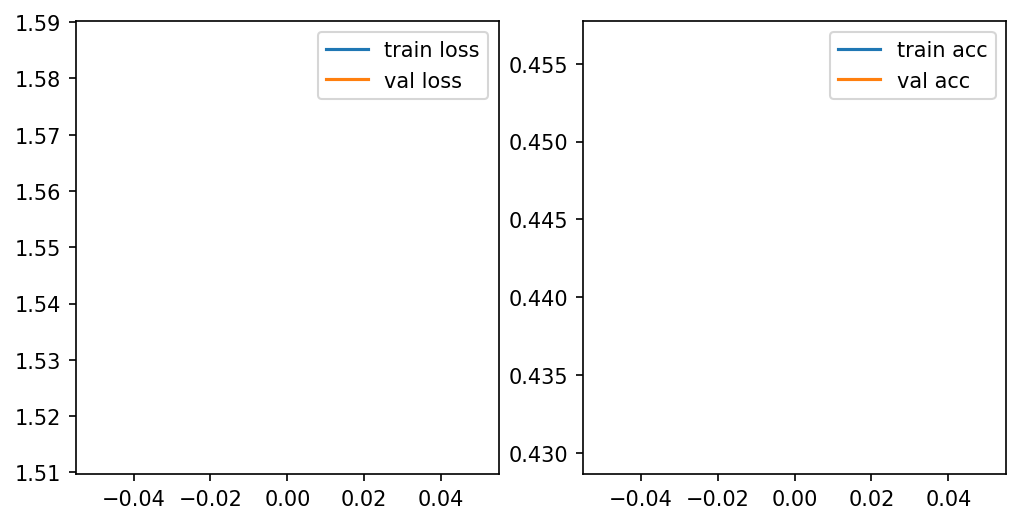

Epoch: 0, Loss: 1.58646, Acc: 42.99%
1563/1563 [==============================] - 507s 324ms/step - loss: 1.5865 - acc: 0.4299 - val_loss: 1.5133 - val_acc: 0.4564


In [34]:
# 알렉스넷 - 배치놈, 데이터오그먼테이션

alexnet = Sequential()

#1st layer : [Conv]+[ReLU]+[Pool]
#32*32*3
alexnet.add(Conv2D(input_shape=(32,32,3),  
                      kernel_size=(3,3),       
                      filters=64,
                      strides=(1,1),
                      padding='same',
                      activation='relu'))
alexnet.add(BatchNormalization()) 
#32*32*64
alexnet.add(MaxPool2D(pool_size=(2,2),
                         strides=(2,2),
                         padding='valid'))

#2nd layer : [Conv]+[ReLU]+[Pool]
#16*16*64
alexnet.add(Conv2D(kernel_size=(3,3),        
                      filters=128,
                      strides=(1,1),
                      padding='same',
                      activation='relu'))
alexnet.add(BatchNormalization()) 
#16*16*128
alexnet.add(MaxPool2D(pool_size=(2,2),
                         strides=(2,2),
                         padding='valid'))

#3rd layer : [Conv]+[ReLU]
#8*8*128
alexnet.add(Conv2D(kernel_size=(3,3),        
                      filters=256,
                      strides=(2,2),
                      padding='same',
                      activation='relu'))
alexnet.add(BatchNormalization()) 

#4th layer : [Conv]+[ReLU]
#4*4*256
alexnet.add(Conv2D(kernel_size=(3,3),       
                      filters=512,
                      strides=(2,2),
                      padding='same',
                      activation='relu'))
alexnet.add(BatchNormalization()) 

#5th layer : [Conv]+[ReLU]
#2*2*512
alexnet.add(Conv2D(kernel_size=(2,2),       
                      filters=1024,
                      strides=(2,2),
                      padding='same',
                      activation='relu'))
alexnet.add(BatchNormalization()) 

#6th layer
#1*1*1024
alexnet.add(Flatten())                         # input_shape 은 처음에만 
alexnet.add(Dense(1024, activation='relu'))
alexnet.add(BatchNormalization()) 

#7th layer
alexnet.add(Dense(256, activation='relu'))
alexnet.add(BatchNormalization()) 

#output
alexnet.add(Dense(10, activation='softmax'))

#alexnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
#alexnet.fit(X_train.reshape(-1,32,32,3), y_train, validation_data=(X_test,y_test), epochs=1, 
#            verbose=1, 
#            callbacks=[PlottingCallback()])


model_bn_da = Sequential()
model_bn_da.add(data_augmentation)
model_bn_da.add(alexnet)

model_bn_da.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model_bn_da.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=1, 
                verbose=1, 
                callbacks=[PlottingCallback()])


In [36]:
model_bn_da.summary()
model_bn_da.evaluate(X_test,y_test)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 10)                4976778   
Total params: 4,976,778
Trainable params: 4,970,250
Non-trainable params: 6,528
_________________________________________________________________
313/313 [==============================] - 6s 18ms/step - loss: 1.5133 - acc: 0.4564


[1.513312578201294, 0.4564000070095062]

In [47]:
# Resnet18

# 32*32*3
input_ = Input(shape=(32,32,3))

# 32*32*64
x = Conv2D(64, kernel_size=3, padding='same', strides=(1,1), use_bias=False, # 레즈넷은 bias 안 씀
           kernel_regularizer=l2(5e-4))(input_)
x = BatchNormalization()(x)
x = ReLU()(x)

# 1st block
# 32*32*64
node = 64
ksize = 3
skip = x
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(1,1), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
# 32*32*64
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(1,1), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = Add()([x, skip])                                                          # 저장해 놓은 skip을 넣어줌
x = ReLU()(x)

# 32*32*64
skip = x
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(1,1), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
# 32*32*64
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(1,1), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = Add()([x, skip])
x = ReLU()(x)

# 2nd block
# 16*16*128
node=128
skip = Conv2D(node, kernel_size=1, padding='same', strides=(2,2), use_bias=False, kernel_regularizer=l2(5e-4))(x)   # 32*32 -> 16*16 으로 크기를 조정해야 함
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(2,2), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
# 16*16*128
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(1,1), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = Add()([x, skip])
x = ReLU()(x)

# 16*16*128
skip = x
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(1,1), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
# 16*16*128
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(1,1), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = Add()([x, skip])
x = ReLU()(x)

# 3rd block
# 8*8*256
node=256
skip = Conv2D(node, kernel_size=1, padding='same', strides=(2,2), use_bias=False, kernel_regularizer=l2(5e-4))(x)   # 16*16 -> 8*8 으로 크기를 조정해야 함
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(2,2), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
# 8*8*256
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(1,1), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = Add()([x, skip])
x = ReLU()(x)

# 8*8*256
skip = x
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(1,1), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
# 8*8*256
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(1,1), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = Add()([x, skip])
x = ReLU()(x)

# 4th block
# 4*4*512
node=512
skip = Conv2D(node, kernel_size=1, padding='same', strides=(2,2), use_bias=False, kernel_regularizer=l2(5e-4))(x)   # 8*8 -> 4*4 으로 크기를 조정해야 함
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(2,2), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
# 4*4*512
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(1,1), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = Add()([x, skip])
x = ReLU()(x)

# 4*4*512
skip = x
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(1,1), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
# 4*4*512
x = Conv2D(node, kernel_size=ksize, padding='same', strides=(1,1), use_bias=False, kernel_regularizer=l2(5e-4))(x)
x = BatchNormalization()(x)
x = Add()([x, skip])
x = ReLU()(x)

# Pooling, Flatten
x = AveragePooling2D(pool_size=(4, 4))(x)         # 4*4*512 -> 1*1*512 로 변경
x = Flatten()(x)                                  # 1*1*512 -> 512 로 변경

# Fully-connected layer
output = Dense(10, activation=tf.nn.softmax)(x)
resnet = tf.keras.Model(input_, output)

data_augmentation = Sequential()
data_augmentation.add(ZeroPadding2D(4, input_shape=(32,32,3)))
data_augmentation.add(RandomCrop(32, 32))
data_augmentation.add(RandomFlip('horizontal'))
data_augmentation.add(RandomRotation(0.05))

model = Sequential()
model.add(data_augmentation)
model.add(resnet)

resnet.summary()
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_156 (Conv2D)             (None, 32, 32, 64)   1728        input_10[0][0]                   
__________________________________________________________________________________________________
batch_normalization_136 (BatchN (None, 32, 32, 64)   256         conv2d_156[0][0]                 
__________________________________________________________________________________________________
re_lu_115 (ReLU)                (None, 32, 32, 64)   0           batch_normalization_136[0][0]    
_______________________________________________________________________________________

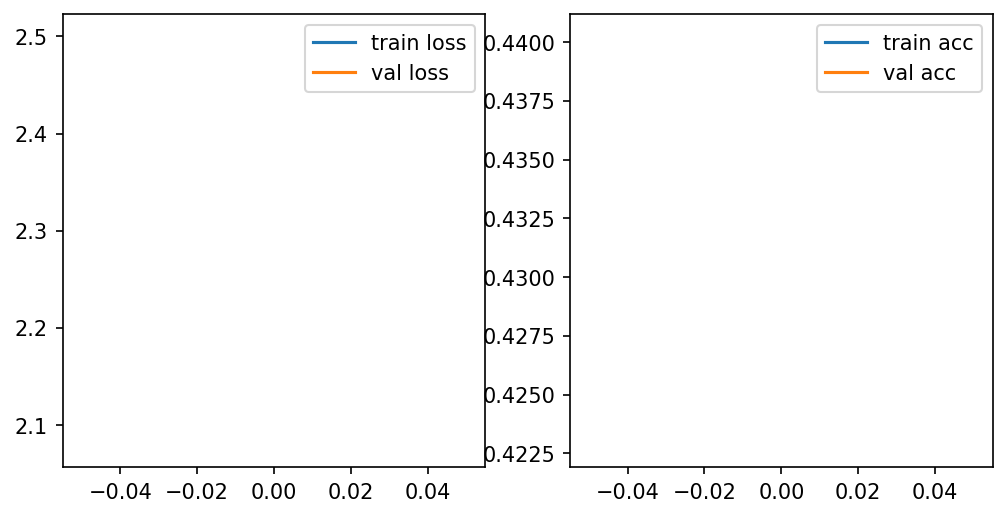

Epoch: 0, Loss: 2.50147, Acc: 42.28%
1563/1563 [==============================] - 1973s 1s/step - loss: 2.5015 - acc: 0.4228 - val_loss: 2.0776 - val_acc: 0.4403


In [48]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=1, verbose=1, callbacks=[PlottingCallback()])

In [50]:
model.summary()
model.evaluate(X_test,y_test)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_20 (Sequential)   (None, 32, 32, 3)         0         
_________________________________________________________________
functional_7 (Functional)    (None, 10)                11179978  
Total params: 11,179,978
Trainable params: 11,172,170
Non-trainable params: 7,808
_________________________________________________________________
313/313 [==============================] - 73s 233ms/step - loss: 2.0776 - acc: 0.4403


[2.077609062194824, 0.44029998779296875]